In [16]:
%matplotlib inline
import numpy as np
from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.animation import FuncAnimation
import math
import random

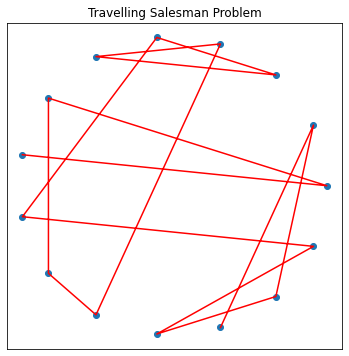

In [17]:
n_cities = 15
n_individuals = 300
radius = 10

cities = ([(math.cos(2*math.pi/n_cities*x)*radius,math.sin(2*math.pi/n_cities*x)*radius) for x in range(0,n_cities)])
distances = pairwise_distances(cities, metric='euclidean')

plotdata = list(cities)
shuffle(plotdata)
plt.figure(figsize=(6,6))
plt.scatter([x[0] for x in plotdata], [x[1] for x in plotdata])
plt.plot([x[0] for x in plotdata], [x[1] for x in plotdata], "r-")
plt.tick_params(bottom=False,top=False,left=False,
                right=False,labelbottom=False,labelleft=False)
plt.title("Travelling Salesman Problem")
plt.show()

In [18]:
def getPopulation(n_cities, n_individuals):
    population = []
    n = 0
    while n < n_individuals:
        individuals = np.random.permutation(n_cities)
        if not any([np.array_equal(individuals, x) for x in population]):
            population.append(individuals)
            n += 1
    return population

pop = getPopulation(n_cities,n_individuals)
#print(pop)

In [91]:
def Innovation(individual):
    innovated = np.array(individual)
    innovated = np.random.shuffle(innovated)
    return innovated

In [20]:
def Mutation(individual):
    mutated = np.array(individual)
    indi1,indi2 = sample(range(len(individual)),2)
    mutated[indi1] = individual[indi2]
    mutated[indi2] = individual[indi1]
    return mutated

In [81]:
def Inversion(individual):
    p = np.random.randint(n_cities)
    k = np.random.randint(p,n_cities)
    inverted = np.array(individual)
    if p == k:
        return None
    else:
        inverted[p:k] = reversed(inverted[p:k])
        return inverted

In [122]:
def Cloning(individual1, individual2):
    n = len(individual1)
    individual1, individual2 = sample(range(n),2)
    result1 = np.array(individual1)
    result2 = np.array(individual2)
    result2 = result2.tolist()
    result1 = result1.tolist()
    result2 = []
    for i in range((result1)):
        result2.append(result1)
    #result2 = result1.copy()
    return result1, result2

In [84]:
def Transposition(individual):
    transpo = np.array(individual)
    p = np.random.randint(n_cities)
    k = np.random.randint(p,n_cities)
    transpo[p:k] = shuffle(transpo[p:k])
    return transpo

In [24]:
def Crossing_over(individual1, individual2):
    n = len(individual1)
    cross_point1, cross_point2 = sample(range(n),2)
    if cross_point1 > cross_point2:
        tmp = cross_point2
        cross_point1 = cross_point2
        cross_point2 = tmp
    result1 = np.array(individual1)
    result2 = np.array(individual2)
    j1 = cross_point1
    j2 = cross_point2
    for i in range(cross_point1,cross_point2):
        while individual2[j1] not in individual1[cross_point1:cross_point2]:
            j1 = (j1+1)%n
        result1[i] = individual2[j1]
        j1 = (j1+1)%n
        while individual1[j2] not in individual2[cross_point1:cross_point2]:
            j2 = (j2+1)%n
        result2[i] = individual1[j2]
        j2 = (j2+1)%n
    return result1, result2

In [130]:
def createOffspring(individual, p_innovation = 0, p_mutation=0.2, p_inversion = 0, 
                   p_cloning = 0, p_transposition = 0, p_crossing_over = 0.4):
    offspring = []

    for x in individual:
        if np.random.rand() <= p_mutation:
            c = Mutation(x)
            if (not any([np.array_equal(c, x) for x in individual]) and 
                not any([np.array_equal(c, x) for x in offspring])):
                offspring.append(c)
        if np.random.rand() <= p_innovation:
            k = Innovation(x)
            if (not any([np.array_equal(k, x) for x in individual]) and 
                not any([np.array_equal(k, x) for x in offspring])):
                offspring.append(k)
        if np.random.rand() <= p_inversion:
            t = Inversion(x)
            if (not any([np.array_equal(t, x) for x in individual]) and 
                not any([np.array_equal(t, x) for x in offspring])):
                offspring.append(t)
        if np.random.rand() <= p_transposition:
            w = Transposition(x)
            if (not any([np.array_equal(w, x) for x in individual]) and 
                not any([np.array_equal(w, x) for x in offspring])):
                offspring.append(w)
    if np.random.rand() <= p_crossing_over:
        for i in range(len(individual)):
            p1, p2 = sample(individual, 2)
            c1, c2 = Crossing_over(p1, p2)
            if (not any([np.array_equal(c1, x) for x in individual]) and 
                not any([np.array_equal(c1, x) for x in offspring])):
                offspring.append(c1)
            if (not any([np.array_equal(c2, x) for x in individual]) and 
                not any([np.array_equal(c2, x) for x in offspring])):
                offspring.append(c2)
    
    if np.random.rand() <= p_cloning:
        p1, p2 = sample(individual, 2)
        c1, c2 = Cloning(p1, p2)
        if (not any([np.array_equal(c1, x) for x in individual]) and 
            not any([np.array_equal(c1, x) for x in offspring])):
            offspring.append(c1)
        if (not any([np.array_equal(c2, x) for x in individual]) and 
            not any([np.array_equal(c2, x) for x in offspring])):
            offspring.append(c2)

    return offspring

In [69]:
def fitness(individual):   
    fitness = 0
    global distances
    
    for i in range(len(individual) - 1):
        fitness += distances[individual[i]][individual[i+1]]
    return fitness

In [70]:
def probabilisticSelection(population, selection_factor, RWS=False, p=[1, 0]):
    total_fitness = sum([fitness(x) for x in population])
    
    population = [[x, (p[0]*(total_fitness - fitness(x))+p[1])/(p[0]*(total_fitness*(len(population)-1))+p[1])] for x in population]
    population.sort(key=lambda x: x[1])
    population = [[x[0], y] for x, y in zip(population, np.cumsum([x[1] for x in population]))]

    new_population = []

    r = np.random.rand()
    for i in range(selection_factor):
        selected_individual = [x for x in population if x[1] >= (r + i/selection_factor)%1][0]
        new_population.append(selected_individual[0])

    return new_population

In [71]:
def elitismReplacement(individual, offspring, n_elite):
    individual.sort(key=lambda x: fitness(x))
    new_population = individual[:n_elite]
    offspring.sort(key=lambda x: fitness(x))
    new_population.extend(offspring[:(len(individual) - n_elite)])
    return new_population

[(-9.781476007338057, -2.079116908177591), (-8.090169943749476, -5.87785252292473), (-5.000000000000004, -8.660254037844384), (-1.0452846326765424, -9.945218953682733), (3.0901699437494723, -9.510565162951536), (6.691306063588578, -7.4314482547739455), (9.135454576426005, -4.0673664307580095), (10.0, 0.0), (9.135454576426008, 4.0673664307580015), (6.691306063588582, 7.431448254773941), (3.0901699437494745, 9.510565162951535), (-1.0452846326765333, 9.945218953682733), (-4.999999999999998, 8.660254037844387), (-8.090169943749473, 5.877852522924733), (-9.781476007338055, 2.079116908177597)]


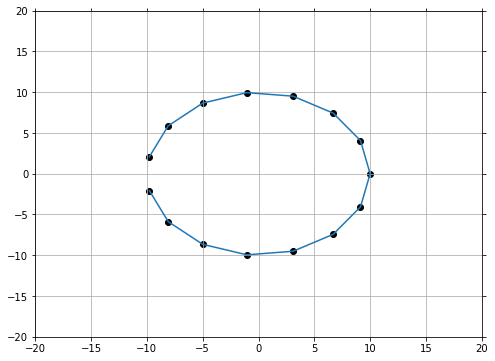

In [131]:
def update(i):#,line,ax):
    global population
    parents = probabilisticSelection(population, 150)
    offspring = createOffspring(parents)
    population = elitismReplacement(population, offspring, 100)
    
    best = min(population, key=lambda x: fitness(x))
    plotdata = [cities[x] for x in best]

    #ax.set_title('iteration #{i}: {d}'.format(i=i, d=fitness(best)))
    #line.set_data([x[0] for x in plotdata], [x[1] for x in plotdata])
    #return line
    return plotdata
    
population = getPopulation(n_cities, n_individuals)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
line, = ax.plot([], [], 'r-')
ax.set_xlim(-(radius+10), (radius+10))
ax.set_ylim(-(radius+10), (radius+10))
ax.grid(True)
ax.scatter([x[0] for x in cities], [x[1] for x in cities], c='k')
ax.tick_params(bottom='off',
                top='off',
                left='off',
                right='off',
                labelbottom='off',
                labelleft='off')

#anim = FuncAnimation(fig, update, frames=np.arange(300), interval=200, blit=True, fargs=(line, ax), repeat=False)

k = []
for i in range(100):
    k.append(update(i))

k_best = k[len(k)-1]
#plt.show()


print(k_best)
plt.plot(*zip(*k_best))
plt.show()